# Keras Model

Taken from: https://www.kaggle.com/code/guillemkami/getting-started-with-nlp-using-jax/notebook

In [1]:
# Setup. Import libraries and load dataframes for Movielens data.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random

tf.__version__

'2.7.0'

In [2]:
# tf.set_random_seed(1); np.random.seed(1); random.seed(1) # Set random seeds for reproducibility
input_dir = 'data/movie-lens'
ratings_path = os.path.join(input_dir, 'rating.csv')

ratings_df = pd.read_csv(ratings_path, usecols=['userId', 'movieId', 'rating', 'y'])

movies_df = pd.read_csv(os.path.join(input_dir, 'movie.csv'), usecols=['movieId', 'title', 'year'])

df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1) # Shuffle

df.sample(5, random_state=1)

,userId,movieId,rating,y,title,year
12904240,85731,1883,4.5,0.974498,Labyrinth,1986
6089380,45008,1221,4.5,0.974498,"Femme Nikita, La (Nikita)",1990
17901393,125144,3948,4.0,0.474498,The Alamo,1960
9024816,122230,3027,3.5,-0.025502,Toy Story 2,1999
11655659,21156,5202,3.0,-0.525502,My Big Fat Greek Wedding,2002


In [3]:
n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        n_movies, n_users, len(df),
    )
)

138,493 distinct users rated 26,744 different movies (total ratings = 20,000,263)


In [4]:
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.summary(line_length=88)

Model: "model"
________________________________________________________________________________________
 Layer (type)                Output Shape       Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]        0         []                            
                                                                                        
 movie_id (InputLayer)       [(None, 1)]        0         []                            
                                                                                        
 user_embedding (Embedding)  (None, 1, 8)       1107952   ['user_id[0][0]']             
                                                                                        
 movie_embedding (Embedding)  (None, 1, 8)      213952    ['movie_id[0][0]']            
                                                                                        
 concatenate (Concatenate)   (None, 1, 16)      0         ['user_embedding[0][0]',      
      

In [5]:
model.compile(
    # Technical note: when using embedding layers, I highly recommend using one of the optimizers
    # found  in tf.train: https://www.tensorflow.org/api_guides/python/train#Optimizers
    # Passing in a string like 'adam' or 'SGD' will load one of keras's optimizers (found under 
    # tf.keras.optimizers). They seem to be much slower on problems like this, because they
    # don't efficiently handle sparse gradient updates.
    tf.compat.v1.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)

In [6]:
history = model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5000,
    epochs=20,
    verbose=0,
    validation_split=.05,
);

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

df_train, df_val = train_test_split(df, test_size=.05, random_state=1)

def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = df_train['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = df_val['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global average rating results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

movies = movies_df.copy().set_index('movieId')
mean_per_movie = df_train.groupby('movieId')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = df_train.groupby('movieId').size()
movies['n_ratings'] = ratings_per_movie
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = df_val.join(mean_per_movie, on='movieId', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Average rating in training set is 3.53 stars
Always predicting global average rating results in Mean Absolute Error=0.84, Mean Squared Error=1.10
Predicting mean per movie results in Mean Absolute Error=0.73, Mean Squared Error=0.88


In [10]:
history.history.keys()

dict_keys(['loss', 'MAE', 'val_loss', 'val_MAE'])

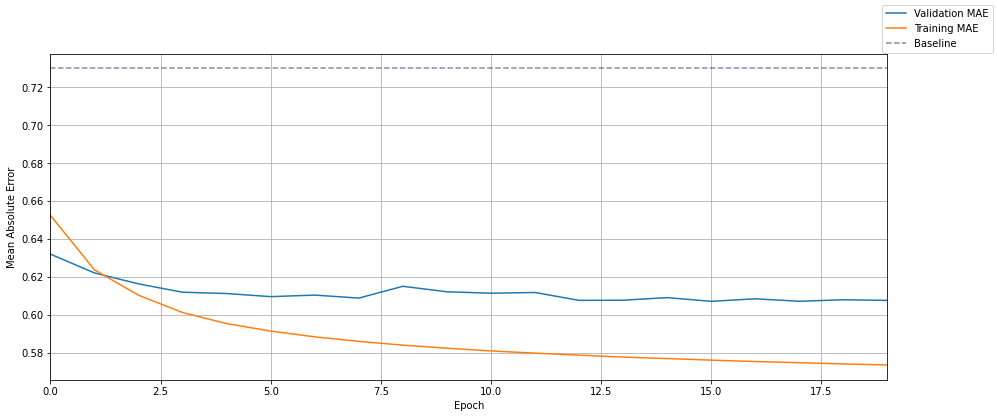

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Validation MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

See how Keras can learn!